# FlatBean

This is a minimal implementation of the symbolic represenation feature in a pulse building library.

In [1]:
%matplotlib notebook
from copy import copy

import numpy as np
import matplotlib.pyplot as plt

from broadbean.segment import Segment, SegmentGroup
from broadbean.element import Element
from broadbean.sequence import Sequence
from broadbean.plotting import plotter

## Segments

Segments are defined with a function and list of parameters that can be strings=symbols or values.
Specific segments (Atoms) are not yet implemented, but they behave identically

The function of a segment must take at least the argument `time`. It should return a numpy array of the same length as `time`.

There are different ways of creating a `Segment`. Let's use a simple sine wave as an example.

In [2]:
def sinefunction(time, x):
    """
    A sine with a phase
    """
    return np.sin(2*np.pi*time + x)

# function arguments may be given up front as numbers
s1 = Segment(function=sinefunction, duration=2, x=np.pi)
# or, more interestingly, as 'symbols'
s2 = Segment(function=sinefunction, duration='pulse_time', x='phase')

The `forge` method of a `Segment` returns the numpy array of the waveform. The `forge` method always needs (at least) to be given the sample rate (SR) at which to play the waveform.

In [3]:
s1.forge(SR=4)

array([  1.22464680e-16,  -1.00000000e+00,  -2.44929360e-16,
         1.00000000e+00,   3.67394040e-16,  -1.00000000e+00,
        -4.89858720e-16,   1.00000000e+00])

What can be forged can also be plotted!

<IPython.core.display.Javascript object>


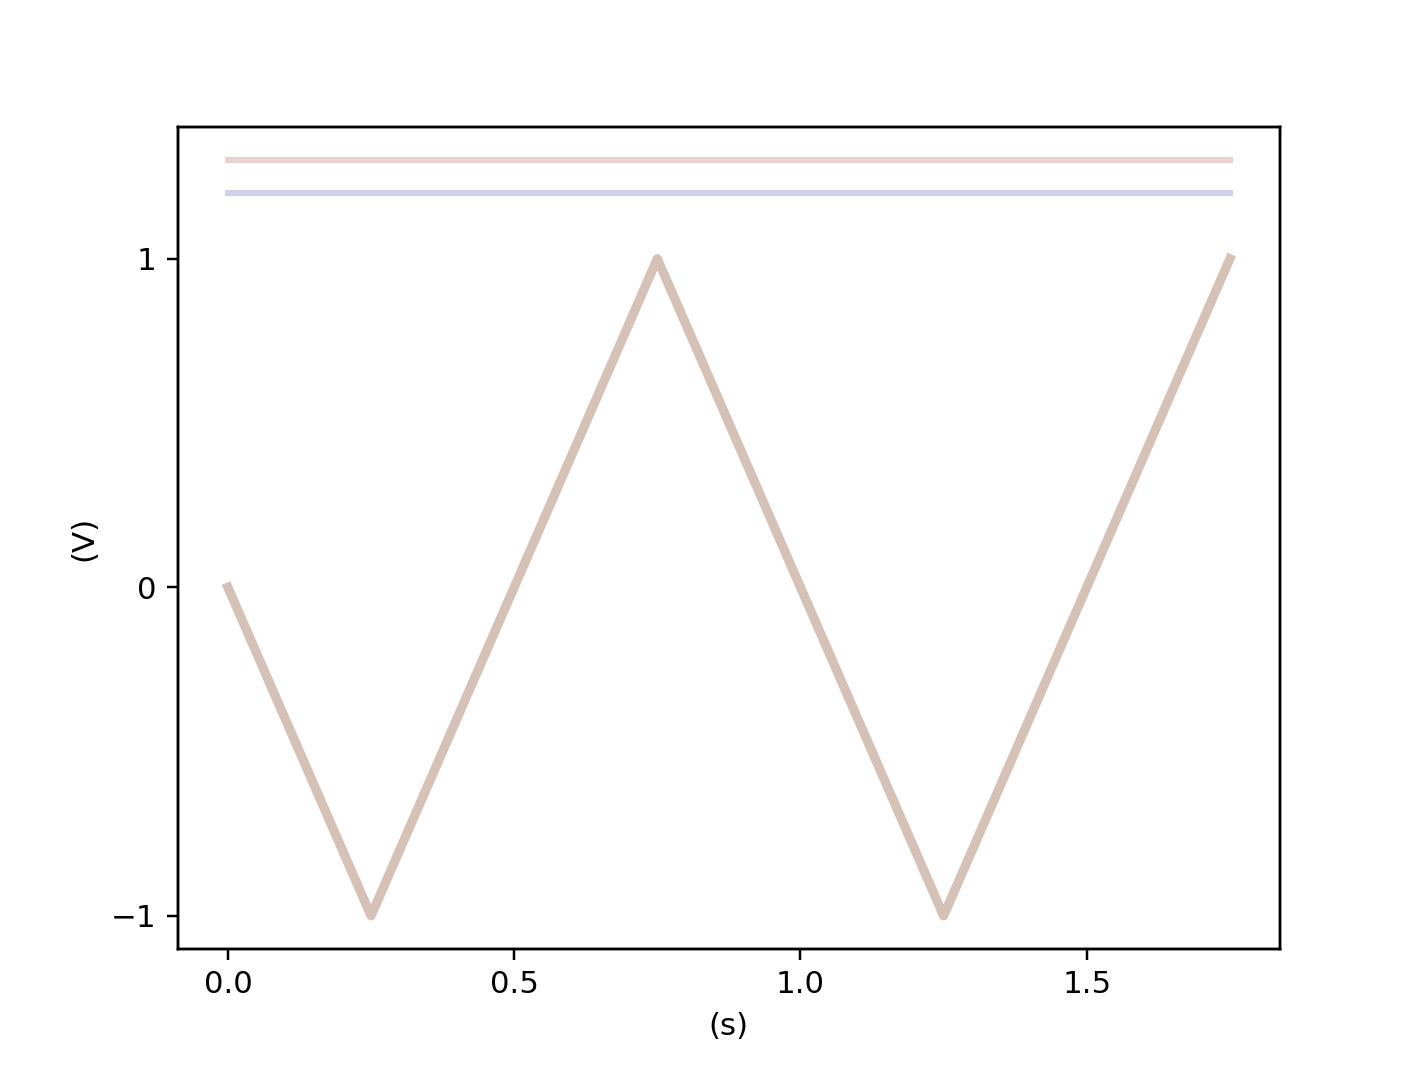

In [4]:
plotter(s1, SR=4)

More generally, `forge` also accepts a dictionary of parameter values (that will then override default values) **NB** that does not currently happen!

In [5]:
values = {'duration':1, 'x':0}
s1.forge(SR=4, **values)

array([  1.22464680e-16,  -1.00000000e+00,  -2.44929360e-16,
         1.00000000e+00,   3.67394040e-16,  -1.00000000e+00,
        -4.89858720e-16,   1.00000000e+00])

Similarly, symbols can be filled out through a dictionary.

In [6]:
values_for_syms = {'pulse_time':2, 'phase':0}
s2.forge(SR=4, **values_for_syms)

array([  0.00000000e+00,   1.00000000e+00,   1.22464680e-16,
        -1.00000000e+00,  -2.44929360e-16,   1.00000000e+00,
         3.67394040e-16,  -1.00000000e+00])

The advantage of symbols is that the same symbol can be used in many `Segment` instances and thus coordinate behaviour across a large and complex pulse sequence.

In order to keep all gates open, we can define a transformation, that does some operation on the symbols defined in the values dict.

(In an equal manner as for the atom there should be a canon of transformations, so that they can easily be serialized and the whole sequence can be uniquely represented with a minimal necessary amount of data.

Such a transformation could be for example a solver for linear equations.)

Here we define the transformation explicitly:

In [21]:
def my_transformation(in_dict):
    out_dict = copy(in_dict)
    #out_dict['total_duration'] = 0 #out_dict['excite_time'] + 8*out_dict['readout_time']
    out_dict['readout_time'] = 8
    return out_dict

def my_other_trans(in_dict):
    out_dict = copy(in_dict)
    out_dict['excite_time'] = out_dict['total_duration'] - out_dict['readout_time']
    return out_dict

The transformation gets associated with a `SegmentGroup` as in the following example. In principle they should be  also attachable to Segments, Elements and Sequences. This allows scoping of names, as the transformations get executed in the same order and can overwrite existing values (*what does this sentence mean?*).

In [25]:
seg1 = Segment(function=sinefunction, duration='excite_time', x=0)
seg2 = Segment(function=sinefunction, duration='readout_time', x=np.pi/2)

times = {'excite_time': 1.5,
         'readout_time': 1,
         'total_duration': 10}

gs = SegmentGroup(seg1, seg2, duration='total_duration', transformation=my_other_trans)
out = gs.forge(100, **times)
#plotter(gs)

<IPython.core.display.Javascript object>


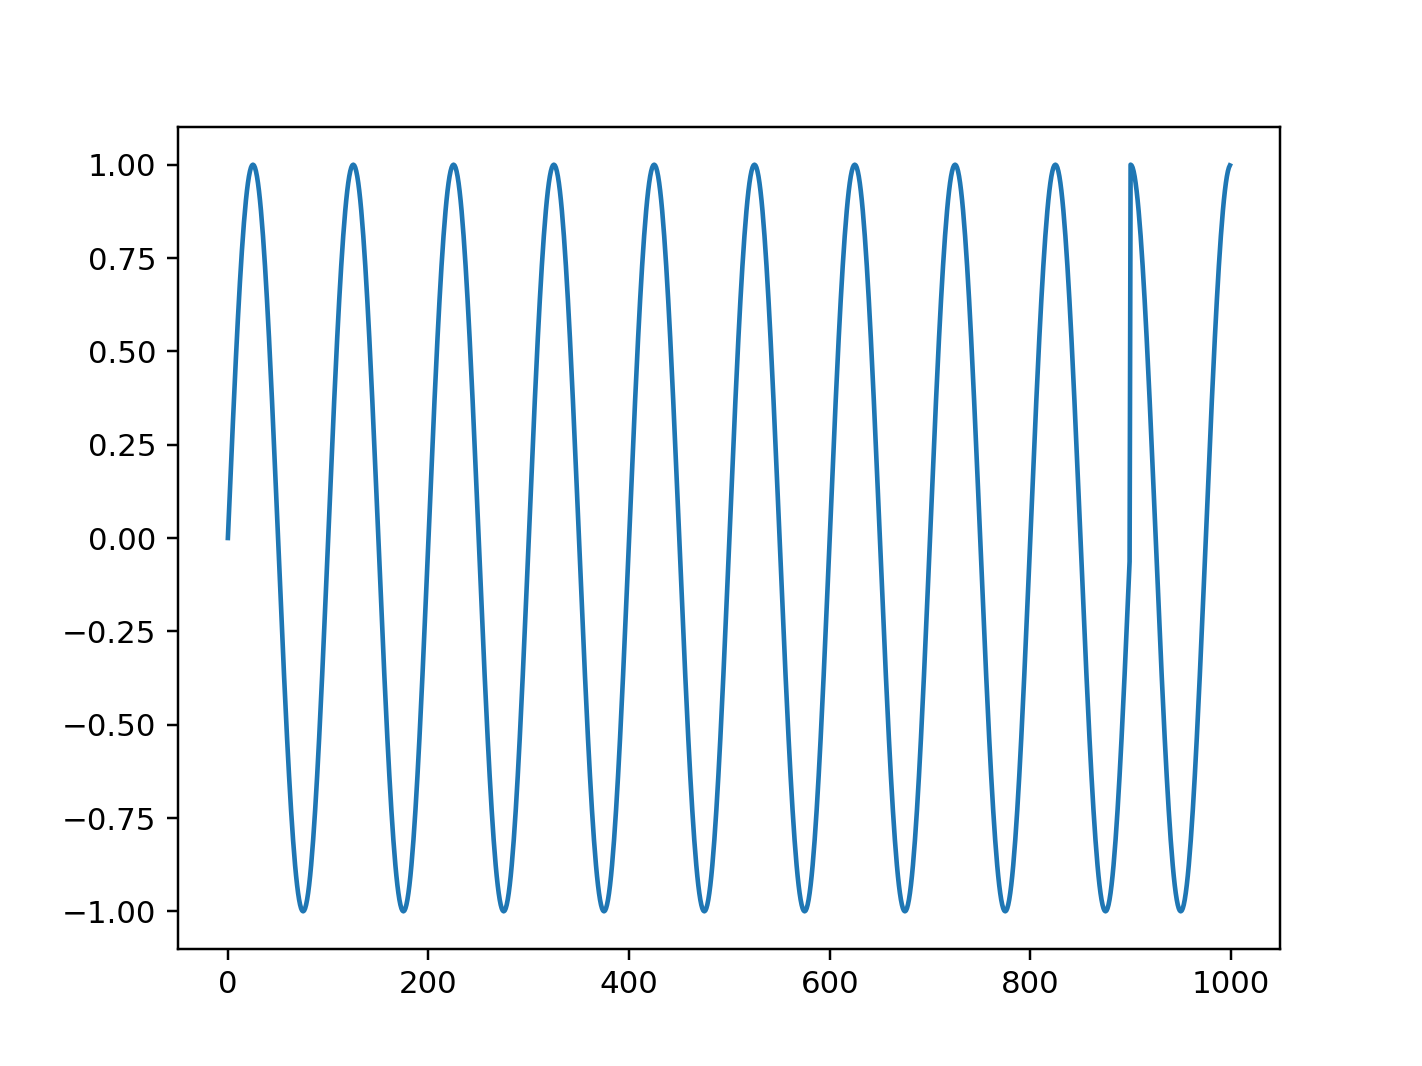

In [26]:
plt.figure()
plt.plot(out)

In [17]:
my_transformation(times)

{'excite_time': 0.5, 'readout_time': 1, 'total_duration': 1.5}

In [18]:
times

{'excite_time': 0.5, 'readout_time': 1}

Elements are straight forward. Here I attach the sequencing options to the Element. I think we should represent jump targets as references to element objects, as in a linked list, and do the derefenciation to indeces in the forging process of the sequence.

In [5]:
e = Element({'myChannel':gs}, {'nr_rep':2})
e.get_duration(waiting_time=1, pulse_time=1)

2

A Sequence is nothing more than a list of Elements. It can have sequencing information like an element and thus becomes a subsequence. (There are many ways in which we can implement subsequences, I don't have any preference yet, it could be a mixin: Sequenceable)

In [6]:
s = Sequence([e])
s.forge(10,{'waiting_time':1, 'pulse_time':2, 'phase': 1})

{0: {'sequencing': {'nr_rep': 2},
  'content': {1: {'data': {'myChannel': array([ 0.84147098,  0.89120736,  0.93203909,  0.96355819,  0.98544973,
             0.99749499,  0.9995736 ,  0.99166481,  0.97384763,  0.94630009,
             0.84147098,  0.89120736,  0.93203909,  0.96355819,  0.98544973,
             0.99749499,  0.9995736 ,  0.99166481,  0.97384763,  0.94630009,
             0.90929743,  0.86320937,  0.8084964 ,  0.74570521,  0.67546318,
             0.59847214,  0.51550137,  0.42737988,  0.33498815,  0.23924933])}}},
  'type': 'element'}}

Forging works as expected.

A main part that needs to be implemented is the creation of a sequence from a list of parameter values. Say make a sequence from phase=1..10. But this should be easy.

In [7]:
plotter(s)

TypeError: forge() got an unexpected keyword argument 'includetime'

In [9]:
type(s)

broadbean.sequence.Sequence